In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [2]:
intr_file = '../ubuntu/data/hg19_intr_clean.fa'
depl_file = '../ubuntu/data/hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    for j in range(n_jumps):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [3]:
kmer = [10]
d = 2
results = []
emb = []
for k in kmer:
    print('Kmer: ',k)
    intr_texts = [' '.join(getKmers(i, k)) for i in intr_seqs]
    depl_texts = [' '.join(getKmers(i, k)) for i in depl_seqs]
    merge_texts = intr_texts + depl_texts
    labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(merge_texts)

    encoded_docs = tokenizer.texts_to_sequences(merge_texts)

Kmer:  10


In [4]:
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

In [5]:
map_model = np.loadtxt("emb_k10_d2")

### One/Many word analysis

In [6]:
import math
import re
color = []
idx = []
imp = []
choice = ['r','g','b','purple', 'grey']
for (i,j) in tokenizer.word_index.items():
    bases = [0]*8
    bases[0] = len(re.findall('at', i))
    bases[1] = len(re.findall('ta', i))
    bases[2] = len(re.findall('cg', i))
    bases[3] = len(re.findall('gc', i))

    at = bases[0]+bases[1]
    cg = bases[2]+bases[3]
    if (at>cg):
        color.append(1)
    elif(cg > at):
        color.append(-1)
    else: 
        color.append(0)
    idx.append(tokenizer.word_index[i])
    imp.append(tokenizer.word_counts[i])

In [7]:
sorted_d = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
sorted_d = sorted_d[::-1]

In [8]:
radius = np.linalg.norm(map_model, axis = 1)

In [9]:
intr_vec = []
intr_r = []
for x in X[0:len(intr_texts)]:
    m = 0
    vx = np.mean(map_model[x,0])
    vy = np.mean(map_model[x,1])
    m = np.argmax(radius[x])
    intr_r.append(map_model[x[m]])
    intr_vec.append([vx,vy])

In [10]:
depl_vec = []
depl_r = []
for x in X[len(intr_texts):]:
    vx = np.mean(map_model[x,0])
    vy = np.mean(map_model[x,1])
    m = np.argmax(radius[x])
    depl_r.append(map_model[x[m]])
    depl_vec.append([vx,vy])

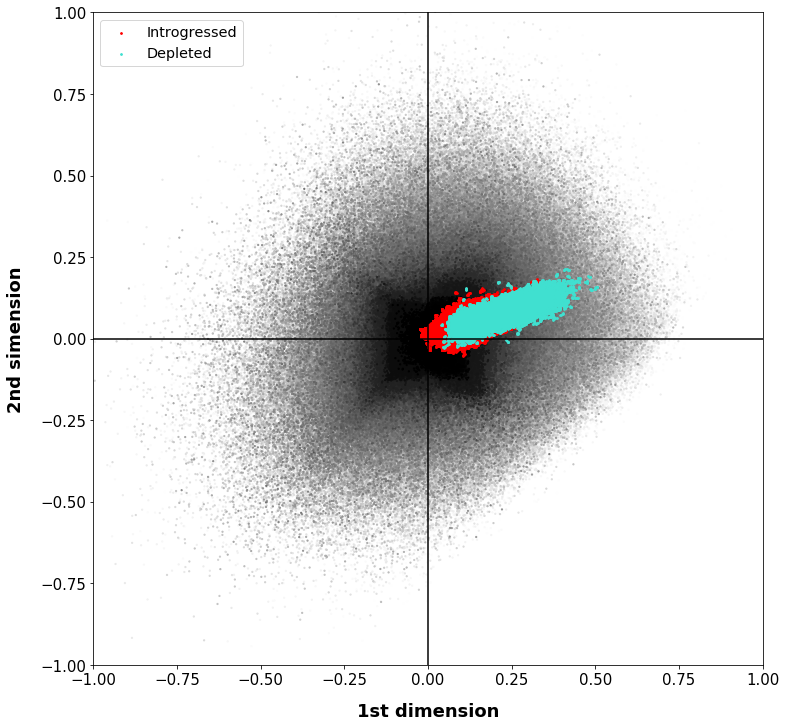

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.scatter(map_model[:-1:,0], map_model[:-1:,1], c = idx, s = 1.5, cmap = 'Greys')
ax.scatter(np.array(intr_vec)[:,0], np.array(intr_vec)[:,1] ,c = 'red', s = 3, label = 'Introgressed')
ax.scatter(np.array(depl_vec)[:,0], np.array(depl_vec)[:,1] ,c = 'turquoise', s = 3, label = 'Depleted')
ax.plot([0,0], [-1,1], c = 'black')
ax.plot([-1,1],[0,0], c = 'black')
ax.set_xlabel('1st dimension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_ylabel('2nd simension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 'x-large')
plt.show()

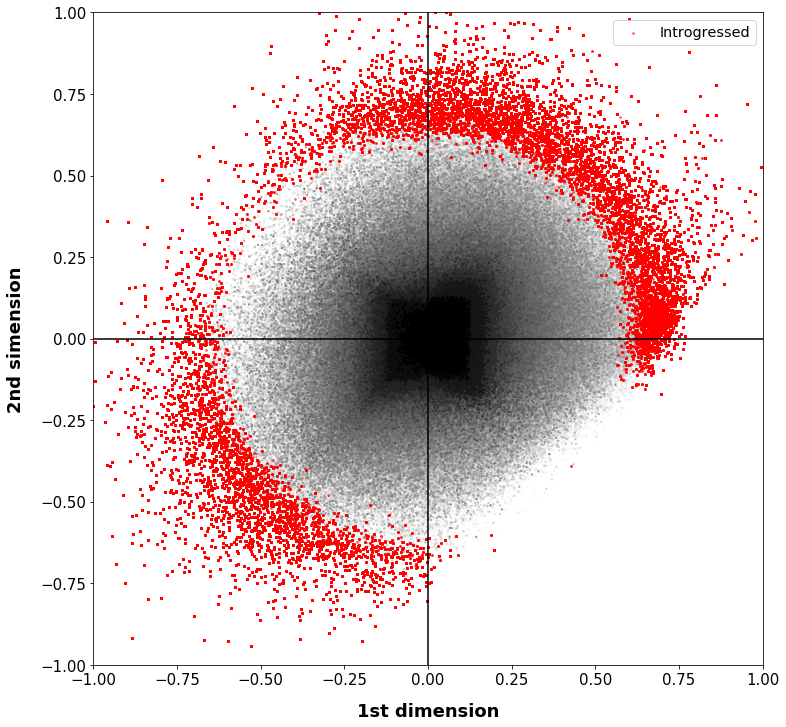

In [36]:
import matplotlib.pyplot as plt
r = np.array(sorted_d)[::-1]
l = r[0:10]
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
c = 0
ax.scatter(map_model[:-1:,0], map_model[:-1:,1], c = idx, s = 1.5, cmap = 'Greys')
ax.scatter(np.array(intr_r)[:,0], np.array(intr_r)[:,1] ,c = 'red', s = 3, alpha = 0.5 ,label = 'Introgressed')
ax.plot([0,0], [-1,1], c = 'black')
ax.plot([-1,1],[0,0], c = 'black')
ax.set_xlabel('1st dimension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_ylabel('2nd simension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 'x-large')
plt.show()

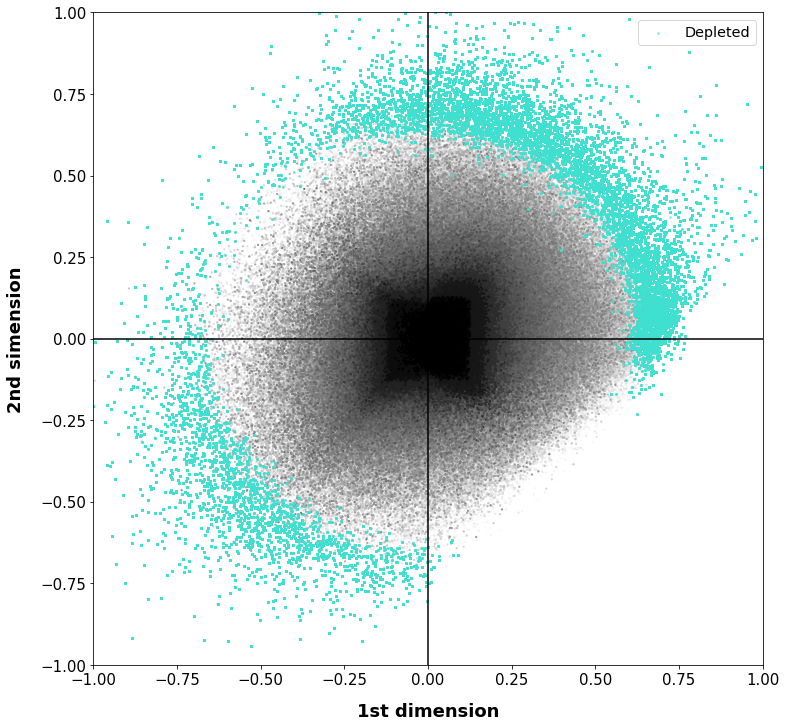

In [42]:
import matplotlib.pyplot as plt
r = np.array(sorted_d)[::-1]
l = r[0:10]
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
c = 0
ax.scatter(map_model[:-1:,0], map_model[:-1:,1], c = idx, s = 1.5, cmap = 'Greys')
ax.scatter(np.array(depl_r)[:,0], np.array(depl_r)[:,1] ,c = 'turquoise', s = 3, alpha = 0.5 ,label = 'Depleted')
ax.plot([0,0], [-1,1], c = 'black')
ax.plot([-1,1],[0,0], c = 'black')
ax.set_xlabel('1st dimension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_ylabel('2nd simension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 'x-large')
plt.show()

### Sentence composition on Depleted/Introgressed Databases

In [139]:
quad_I = [0]*4
for s in X[0:len(intr_texts)]:
    for (i,j) in map_model[s]:
        if(i>0 and j >0):
            quad_I[0] += 1
            continue
        elif(i<0 and j >0):
            quad_I[1] += 1
            continue
        elif(i<0 and j<0):
            quad_I[2] += 1
            continue
        elif(i>0 and j<0):
            quad_I[3] += 1
            continue

In [142]:
np.array(quad_I)/sum(quad_I)

array([0.37399769, 0.17366193, 0.21229424, 0.24004613])

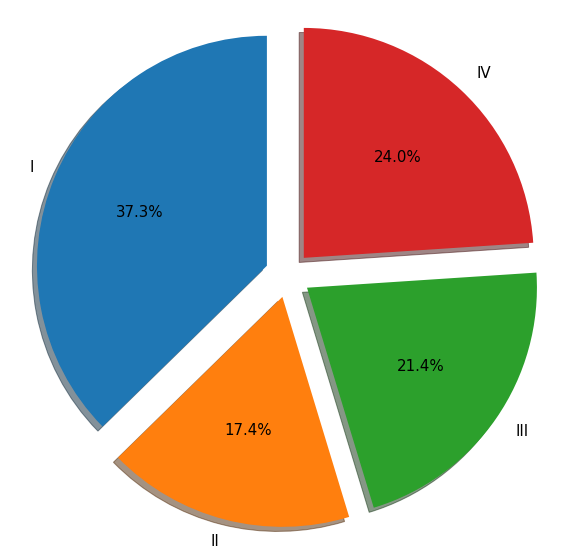

In [54]:
labels = 'I', 'II', 'III', 'IV'
sizes = [37.4, 17.4, 21.4, 24.0]
explode = (0.1, 0.1, 0.1, 0.1)

fig1, ax1 = plt.subplots(figsize = (10,10))
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
for i in range(4):
    texts[i].set_fontsize(15)
    autotexts[i].set_fontsize(15)
plt.show()

In [137]:
quad_D = [0]*4
for s in X[len(intr_texts):]:
    for (i,j) in map_model[s]:
        if(i>0 and j >0):
            quad_D[0] += 1
            continue
        elif(i<0 and j >0):
            quad_D[1] += 1
            continue
        elif(i<0 and j<0):
            quad_D[2] += 1
            continue
        elif(i>0 and j<0):
            quad_D[3] += 1
            continue

In [143]:
np.array(quad_D)/sum(quad_D)

array([0.50615756, 0.1086868 , 0.11629699, 0.26885864])

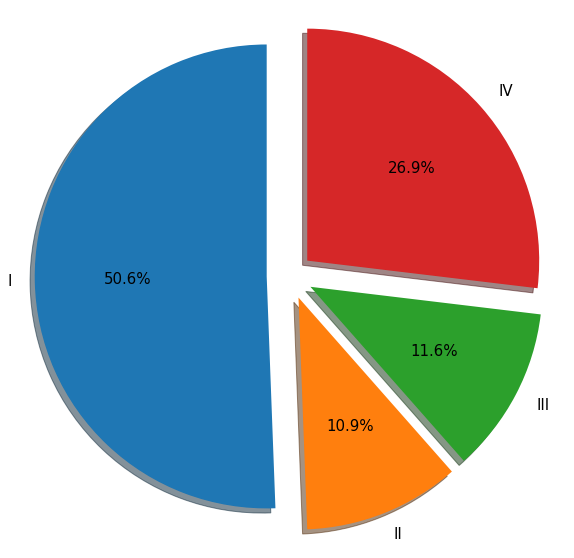

In [55]:
labels = 'I', 'II', 'III', 'IV'
sizes = [50.6, 10.9, 11.6, 26.9]
explode = (0.1, 0.1, 0.1, 0.1)

fig1, ax1 = plt.subplots(figsize = (10,10))
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
for i in range(4):
    texts[i].set_fontsize(15)
    autotexts[i].set_fontsize(15)
plt.show()

### Analysis on each quadrant

In [72]:
q1=[]
q2=[]
q3=[]
q4=[]

for i,j in tokenizer.word_index.items():
        (k1,k2) = (map_model[j-1,0],map_model[j-1,1])
        if(k1>0 and k2 >0):
            q1.append(i)
            continue
        elif(k1<0 and k2 >0):
            q2.append(i)
            continue
        elif(k1<0 and k2<0):
            q3.append(i)
            continue
        elif(k1>0 and k2<0):
            q4.append(i)
            continue

In [79]:
print('Q1: ',len(q1)/vocab_size)
print('Q2: ',len(q2)/vocab_size)
print('Q3: ',len(q3)/vocab_size)
print('Q4: ',len(q4)/vocab_size)

Q1:  0.4050832523156238
Q2:  0.15694454152448853
Q3:  0.19987651418392396
Q4:  0.2380946329209373


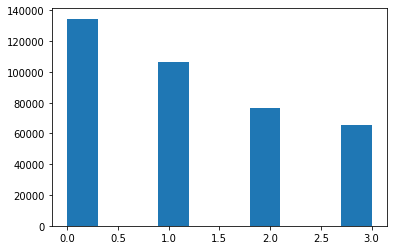

In [83]:
h = []
for i in q1:
    bases = [0]*4
    bases[0] = len(re.findall('a', i))
    bases[1] = len(re.findall('t', i))
    bases[2] = len(re.findall('c', i))
    bases[3] = len(re.findall('g', i))
    h.append(np.argmax(bases))
plt.hist(h)
plt.show()

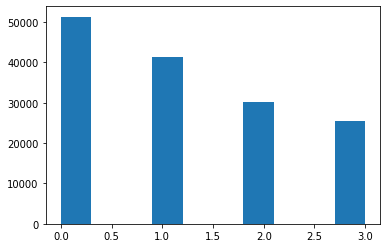

In [84]:
h = []
for i in q2:
    bases = [0]*4
    bases[0] = len(re.findall('a', i))
    bases[1] = len(re.findall('t', i))
    bases[2] = len(re.findall('c', i))
    bases[3] = len(re.findall('g', i))
    h.append(np.argmax(bases))
plt.hist(h)
plt.show()

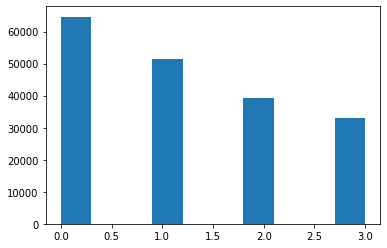

In [85]:
h = []
for i in q3:
    bases = [0]*4
    bases[0] = len(re.findall('a', i))
    bases[1] = len(re.findall('t', i))
    bases[2] = len(re.findall('c', i))
    bases[3] = len(re.findall('g', i))
    h.append(np.argmax(bases))
plt.hist(h)
plt.show()

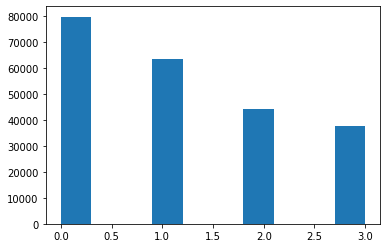

In [86]:
h = []
for i in q4:
    bases = [0]*4
    bases[0] = len(re.findall('a', i))
    bases[1] = len(re.findall('t', i))
    bases[2] = len(re.findall('c', i))
    bases[3] = len(re.findall('g', i))
    h.append(np.argmax(bases))
plt.hist(h)
plt.show()

### Position of high/low frequency words

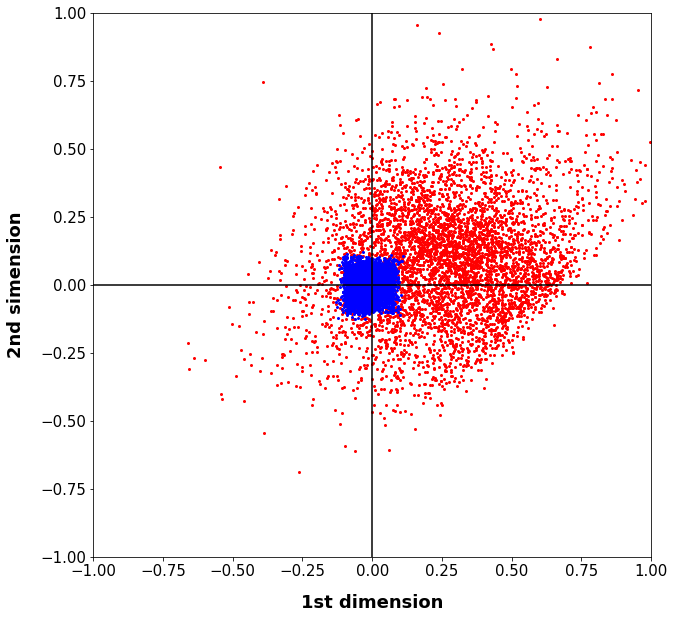

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
l = np.array(sorted_d)[:5000,0]
r = np.array(sorted_d)[-5000:,0]
ax.plot([0,0], [-1,1], c = 'black')
ax.plot([-1,1],[0,0], c = 'black')
ax.set_xlabel('1st dimension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_ylabel('2nd simension',fontsize = 18, labelpad = 15, weight = 'semibold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for (i,j) in tokenizer.word_index.items():
    if(i in l):
        ax.scatter(map_model[j-1,0], map_model[j-1,1], c = 'red', s = 4)
for (i,j) in tokenizer.word_index.items():
    if(i in r):
        ax.scatter(map_model[j-1,0], map_model[j-1,1], c = 'blue', s = 4)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

### AT-rich words

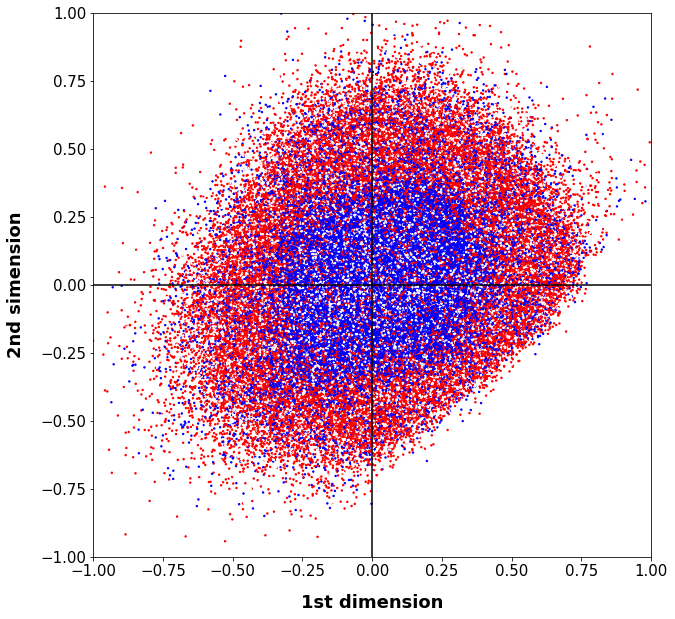

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
s = ax.scatter(map_model[:-1:,0], map_model[:-1:,1], c = color, s = 2, cmap = 'bwr')
ax.plot([0,0], [-1,1], c = 'black')
ax.plot([-1,1],[0,0], c = 'black')
ax.set_xlabel('1st dimension',fontsize = 18, labelpad = 15, weight = 'semibold')
ax.set_ylabel('2nd simension',fontsize = 18, labelpad = 15, weight = 'semibold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()